# Regresión Lineal Ordinal

### Xukai Chen & Julio Menéndez Sánchez
### Curso: TDM - 2022/2023



Para  poder entender el concepto esta regresión y el problema a resolver, debemos recordar y recurrir a los conceptos basicos del data science, las variables.

Como ya sabemos, tanto regresión como clasificación, son un modelo de estimacion que tienen como objetivo predecir una relacion de dependencia entre una variable independiente  *Y* y una o varias variables dependientes  *X*.

<img src="./images/regr_cfc.png" alt="regre_cfc.png" width="600"/>

#### Los ejemplos más destacados de ambos tipos de algoritmos 
* Regresión lineal: la variable independiente a predecir es del tipo **continuo**
  * El peso y la altura de una persona
  * salario de una persona
  * distancia de un recorrido 
  * ...
  
* Regresion logística: mientras este predice variables **nominales**
  * Frutas y verduras
  * region
  * grupo sanguineo
  * ...

Es decir tanto el algoritmo de regresión como el de clasificación surgieron para adecuar a las caracteristas de estos tipos de variable, para poder predecirlos con alta precision y exhaustividad.

Sin embargo, existe todavía un tipo de variable que es muy comun, se trata de una variable **ordinal**, por ejemplo, el nivel de satifaccion de las encuestas, la nota descriptica de la evaluacion del trimestre, puestos conseguidos en los deportes competitivos...

Como se puede apreciar es como una mezcla de los dos tipos de variables mencionados anteriormente, donde no puede tomar cualquier valor entre dos valores consecutivos pero mantiene cierta relacion de continuidad, el motivo por el cual tampoco puede considerarse como variable nominal, ya que los valores no son independientes entre ellos, es decir, es erronea la prediccion de una variable ordinal si tuviera que elegir entre *Muy satisfecho* y *Muy insatisfecho*.

<img src="./images/satisfaccion.jpg" alt="satisfaccion.jpg" width="1000"/>

##### A continuación vamos a ver varios metodos regresion y clasificacion los cuales podemos obtener una aproximacion a la solucion:

## Inicialización

Inicilización de pyspark

In [1]:
# primero lo descargamos en local
import pyspark                                 # only run after findspark.init()
from pyspark.sql import SparkSession
import urllib
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

23/01/17 19:30:22 WARN Utils: Your hostname, nat7216-dell resolves to a loopback address: 127.0.1.1; using 10.8.7.52 instead (on interface wlp3s0)
23/01/17 19:30:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/17 19:30:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/01/17 19:30:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Funciones útiles 

A continuación se proporcionan algunas de las funciones que pueden ser útiles, por ejemplo, las funciones para la evaluación de los modelos creados.

In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline
import pyspark.sql.functions as f 
import numpy as np


def create_spark_dataframe(file):
    """crea dataframe spark a partir de un fichero

    Args:
        file (path): ruta del fichero
    """
    df = spark.read.format("com.databricks.spark.csv").options(header='true', inferschema='true').load(file)
    return df

def accuracy(predictions, label, prediction="prediction"):
    """calcular la exhaustitud de la prediccion

    Args:
        predictions (): predicciones obtenidas
        label (col): columna de los valores reales 
        prediction (str, optional): columna de la prediccion. Defaults to "prediction".
    """
    evaluator = MulticlassClassificationEvaluator(labelCol=label, predictionCol = prediction, metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Classification accuracy = %g" % (accuracy))

def f1(predictions, label, prediction="prediction"):
    """calcular la F-Measure de la prediccion

    Args:
        predictions (_type_):  predicciones obtenidas
        label (col): columna de los valores reales 
        prediction (str, optional): columna de la prediccion. Defaults to "prediction".
    """
    evaluator = MulticlassClassificationEvaluator(labelCol=label, predictionCol=prediction, metricName="f1")
    f1 = evaluator.evaluate(predictions)
    print("Classification f1 score= " + str(f1))

def calcular_matriz_confusion(predictions,label):
    """Mostrar la matriz de confusion

    Args:
        predictions (_type_):  predicciones obtenidas
        label (col): columna de los valores reales 
    """
    preds_and_labels = predictions.select(['prediction', label])
    # hay que convertir las columnas prediction label en una tupla
    metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
    cm = metrics.confusionMatrix()
    
    cm = cm.toArray().astype(np.int64)
    print(cm)
    fig, ax = plt.subplots(figsize=(4,4))
    ConfusionMatrixDisplay(cm, display_labels=["0.0","1.0", "2.0"]).plot(ax =ax)


## Carga de datos



A continuación se describe cada una de las columnas del dataframe:

* `Sales`: Ventas unitarias de cierto producto (en miles) en cada ubicación
* `CompPrice`: Precio cobrado en cada ubicación
* `Income`:Nivel de ingresos 
* `Advertising`:  Presupuesto de publicidad local para la empresa en cada ubicación
* `Population`: población en la región
* `Price`: Costes
* `Age`: Edad media de la población
* `Education`: Nivel de educación en cada lugar
* `Urban`: Un factor con niveles ``No`` y ``Sí`` para indicar si la tienda
   está en una zona urbana o rural
* `ShelveLoc`: Un factor con niveles ``Malo``, ``Bueno`` y ``Medio`` que indica el
   calidad de la ubicación
* `US`: Un factor con niveles ``No`` y ``Sí`` para indicar si la tienda
   está en los Estados Unidos o no



In [3]:
file = "./carkids.csv"
# ahora llamamos a la función
df = create_spark_dataframe(file)
df.show(5)

+-----+---------+------+-----------+----------+-----+---+---------+-----+---------+---+
|Sales|CompPrice|Income|Advertising|Population|Price|Age|Education|Urban|ShelveLoc| US|
+-----+---------+------+-----------+----------+-----+---+---------+-----+---------+---+
|  9.5|      138|    73|         11|       276|  120| 42|       17|  Yes|      Bad|Yes|
|11.22|      111|    48|         16|       260|   83| 65|       10|  Yes|     Good|Yes|
|10.06|      113|    35|         10|       269|   80| 59|       12|  Yes|   Medium|Yes|
|  7.4|      117|   100|          4|       466|   97| 55|       14|  Yes|   Medium|Yes|
| 4.15|      141|    64|          3|       340|  128| 38|       13|  Yes|      Bad| No|
+-----+---------+------+-----------+----------+-----+---+---------+-----+---------+---+
only showing top 5 rows



## Procesado de datos

Hay que realizar un pre-procesado de las variables ordinales y nominales:

* `Sales`       => `volumen_ventas`: se divide en tres intervalos considerando como `alto`, `medio`, `bajo`
* `ShelveLoc`   => `ShelveLocIndex`: convertir ``Malo``, ``Bueno`` y ``Medio`` en numeros consecutivos enteros
* `Urban`       => `UrbanIndex`: procesado de variable nominal `0` y `1`
* `US`          => `USIndex`: procesado de variable nominal `0` y `1`

In [8]:
from pyspark.sql.functions import when
# procesado de la variable ordinal
_df = df.withColumn('ShelveLocIndex', when(df.ShelveLoc == 'Bad', 0.0).when(df.ShelveLoc == 'Medium', 1.0).otherwise(2.0))
# arbitrariamente se divide el volumen de ventas en tres categorias
_df = _df.withColumn('volumen_ventas', when(df.Sales<5.5, 0.0).when((df.Sales<9) & (df.Sales>=5.5), 1.0).otherwise(2.0))
_df.show(5)

# procesado de las variables nominales mediante StringIndexer
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="Urban", outputCol="UrbanIndex")
indexed_model = indexer.fit(_df)
_df = indexed_model.transform(_df)
indexer = StringIndexer(inputCol="US", outputCol="USIndex")
indexed_model = indexer.fit(_df)
_df = indexed_model.transform(_df)

# descartar las columnas originales
_df = _df.drop('Urban').drop('US').drop('Sales').drop('ShelveLoc')
_df.show(20)

+-----+---------+------+-----------+----------+-----+---+---------+-----+---------+---+--------------+--------------+
|Sales|CompPrice|Income|Advertising|Population|Price|Age|Education|Urban|ShelveLoc| US|ShelveLocIndex|volumen_ventas|
+-----+---------+------+-----------+----------+-----+---+---------+-----+---------+---+--------------+--------------+
|  9.5|      138|    73|         11|       276|  120| 42|       17|  Yes|      Bad|Yes|           0.0|           2.0|
|11.22|      111|    48|         16|       260|   83| 65|       10|  Yes|     Good|Yes|           2.0|           2.0|
|10.06|      113|    35|         10|       269|   80| 59|       12|  Yes|   Medium|Yes|           1.0|           2.0|
|  7.4|      117|   100|          4|       466|   97| 55|       14|  Yes|   Medium|Yes|           1.0|           1.0|
| 4.15|      141|    64|          3|       340|  128| 38|       13|  Yes|      Bad| No|           0.0|           0.0|
+-----+---------+------+-----------+----------+-----+---

In [9]:
from pyspark.ml.feature import VectorAssembler

# crear una columna feature que consiste en una lista de todas las variables dependientes
cols = _df.columns
cols.remove('volumen_ventas')
assembler = VectorAssembler(inputCols = cols, outputCol ='features')
df_features = assembler.transform(_df)
df_features.show(5)

+---------+------+-----------+----------+-----+---+---------+--------------+--------------+----------+-------+--------------------+
|CompPrice|Income|Advertising|Population|Price|Age|Education|ShelveLocIndex|volumen_ventas|UrbanIndex|USIndex|            features|
+---------+------+-----------+----------+-----+---+---------+--------------+--------------+----------+-------+--------------------+
|      138|    73|         11|       276|  120| 42|       17|           0.0|           2.0|       1.0|    1.0|[138.0,73.0,11.0,...|
|      111|    48|         16|       260|   83| 65|       10|           2.0|           2.0|       1.0|    1.0|[111.0,48.0,16.0,...|
|      113|    35|         10|       269|   80| 59|       12|           1.0|           2.0|       1.0|    1.0|[113.0,35.0,10.0,...|
|      117|   100|          4|       466|   97| 55|       14|           1.0|           1.0|       1.0|    1.0|[117.0,100.0,4.0,...|
|      141|    64|          3|       340|  128| 38|       13|           0.0|

### Train y Test

División entre entrenamiento y test.
* 70% de valores para entrenar 
* 30% para test. 


In [10]:
# Sol:
df_features = df_features.select(['volumen_ventas', 'features'])
train, test = df_features.randomSplit([0.7, 0.3], seed = 1234)
df_features.show(5)

+--------------+--------------------+
|volumen_ventas|            features|
+--------------+--------------------+
|           2.0|[138.0,73.0,11.0,...|
|           2.0|[111.0,48.0,16.0,...|
|           2.0|[113.0,35.0,10.0,...|
|           1.0|[117.0,100.0,4.0,...|
|           0.0|[141.0,64.0,3.0,3...|
+--------------+--------------------+
only showing top 5 rows



## 1. Clasificacion mediante Regresion Logística

1. **Se utilizada la distribucion multinomial para clasificar**
2. **Mediante un crossValidator se obtiene los mejores hiperparametros**
3. **Se evalua cada modelo generado utilizando la metrica F-Measure**

In [11]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# regresion logistica utilizando la distribucion multinomial
mlr = LogisticRegression(labelCol="volumen_ventas", family="multinomial")

# conjunto de combinaciones de parametros
paramGrid_mlr = ParamGridBuilder().baseOn([mlr.labelCol, 'volumen_ventas'])\
             .baseOn([mlr.family, 'multinomial'])  \
             .addGrid(mlr.regParam, [0.01, 0.1, 0.5, 1.0, 2.0]) \
            .addGrid(mlr.elasticNetParam, [0.0, 0.5, 1.0]) \
             .build()

# evaluador del modelo
cvEvaluator= MulticlassClassificationEvaluator(metricName="f1", labelCol='volumen_ventas')

# cross validato para obtener la mejor configuracion
cv_mlr = CrossValidator(estimator=mlr, estimatorParamMaps=paramGrid_mlr, evaluator=cvEvaluator)
cvModel_mlr = cv_mlr.fit(train)

def printBestParam(cvModel):
    """Printea los parametros del mejor modelo

    Args:
        cvModel (model): modelo del crossValidator
    """
    bestModel = cvModel.bestModel
    bestParams = bestModel.extractParamMap()
    for key in bestParams.keys():
        print(key,': ', bestParams[key])

printBestParam(cvModel_mlr)

LogisticRegression_9dcbb17e0d69__aggregationDepth :  2
LogisticRegression_9dcbb17e0d69__elasticNetParam :  1.0
LogisticRegression_9dcbb17e0d69__family :  multinomial
LogisticRegression_9dcbb17e0d69__featuresCol :  features
LogisticRegression_9dcbb17e0d69__fitIntercept :  True
LogisticRegression_9dcbb17e0d69__labelCol :  volumen_ventas
LogisticRegression_9dcbb17e0d69__maxBlockSizeInMB :  0.0
LogisticRegression_9dcbb17e0d69__maxIter :  100
LogisticRegression_9dcbb17e0d69__predictionCol :  prediction
LogisticRegression_9dcbb17e0d69__probabilityCol :  probability
LogisticRegression_9dcbb17e0d69__rawPredictionCol :  rawPrediction
LogisticRegression_9dcbb17e0d69__regParam :  0.01
LogisticRegression_9dcbb17e0d69__standardization :  True
LogisticRegression_9dcbb17e0d69__threshold :  0.5
LogisticRegression_9dcbb17e0d69__tol :  1e-06


#### Construye la regresion logistica con los mejores parametros y muestra los detalles del modelo

**Utilizando la instancia *SUMMARY* del modelo de regresion logistica nos devuelve una serie de carateristicas que describen al modelo**

In [23]:
mlr_best = LogisticRegression(labelCol="volumen_ventas", family="multinomial", regParam=0.01, elasticNetParam=0.1)
mlrModel_best = mlr_best.fit(train)

print("Coefficients: \n" + str(mlrModel_best.coefficientMatrix))
print("Intercept: " + str(mlrModel_best.interceptVector))

trainingSummary = mlrModel_best.summary
    
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Coefficients: 
DenseMatrix([[-6.89277349e-02, -1.46699078e-02, -9.30925728e-02,
               8.11894307e-04,  7.20185828e-02,  4.12859356e-02,
               4.04780387e-02, -1.68786214e+00, -2.04709461e-01,
              -4.42074944e-01],
             [ 0.00000000e+00,  0.00000000e+00, -1.80095910e-02,
              -1.21458067e-03,  0.00000000e+00, -1.77208703e-03,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
              -1.52973654e-01],
             [ 6.15478547e-02,  1.08205759e-02,  1.29799116e-01,
               0.00000000e+00, -7.54036426e-02, -3.19310272e-02,
              -4.02600285e-02,  1.79311470e+00,  2.79490561e-02,
               8.17224663e-01]])
Intercept: [-0.02669056957111654,1.3978882434108273,-1.3711976738397105]
Accuracy: 0.77140549273021
FPR: 0.16177338029435925
TPR: 0.7714054927302101
F-measure: 0.7709023968484162
Precision: 0.7753299909953563
Recall: 0.7714054927302101


#### F1 y la matriz de confusión

Classification f1 score= 0.7395327129158156


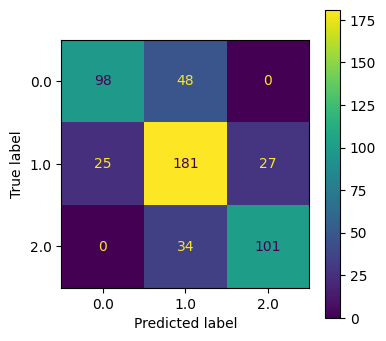

In [21]:
predictions_mlr = mlrModel_best.transform(test)
f1(predictions_mlr, 'volumen_ventas')
calcular_matriz_confusion(predictions_mlr, 'volumen_ventas')

**Oberservación**

No se observa ningun falso negativo o falso positivo entre los valores no consecutivos de la variable a predecir, es decir, entre los valores *bajo* y *alto*. Creemos que al estar ordenado por los numeros que estan asignados, el algoritmo parece que clasifica e identifican bien el rango de los valores que pueden tomar dadas unas variables dependientes, sin embargo no se ha encontrado una manera de establecer los umbrales, donde a partir de los cuales el algoritmo decide la predición sea uno u otro como se podía configurar el parametro *threshold* con el mismo algoritmo utilizado la distribuición *binomial*.   

## 2. Clasificacion mediante OneVsRest

OneVsRest es un ejemplo de  aprendizaje automático para realizar una clasificación multiclase dado un clasificador base a partir del cual realiza una clasificación binaria de forma eficiente. También se conoce como "One-vs-All".

OneVsRest se implementa como un estimador. Para el clasificador base, toma instancias del dicho clasificador y crea un problema de clasificación binaria para cada una de las k clases. El clasificador para la clase i se entrena para predecir si la etiqueta es i o no, distinguiendo la clase i del resto de clases.

Las predicciones se realizan evaluando cada clasificador binario y el índice del clasificador más fiable se utiliza como etiqueta.

Classification f1 score= 0.7312031466859084


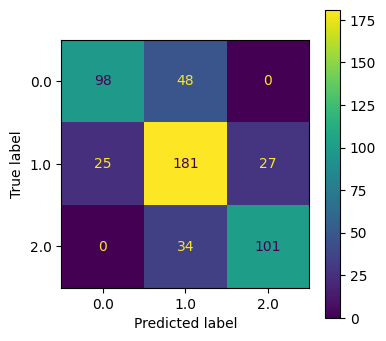

In [24]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lr = LogisticRegression(labelCol="volumen_ventas", family="binomial")

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(labelCol="volumen_ventas", classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(train)

# score the model on test data.
predictions_ovr = ovrModel.transform(test)

f1(predictions_ovr, "volumen_ventas")
calcular_matriz_confusion(predictions_mlr, 'volumen_ventas')

**Obervación**

Se obtiene una evaluacion de f1 ligeramente menor que la regresion multinomial pero la matriz de confusion es la misma, y tambien igualmente se observa que tampoco hay falsos positivos o negativos entre los valores no consecutivos(0.0, 2.0).

## 3. Clasificacion mediante Regresion Lineal

Se utilizar el modelo GeneralizedLinearReggression configurado:
* Distribucion binomial
* Funcion de enlace `logit` y `probit` (La función de enlace proporciona la relación entre el predictor lineal y la media de la función de distribución.)

#### Función logit y probit
![Funcion logit](./images/Logit-vs-probit-models.png)


## 3. Clasificacion mediante Regresion lineal mediante un modelo acumulativo

#### Procesado de los datos

<img src="./images/cumulative.png" alt="cumulative.jpg" width="800"/>

Siendo **n** el número de valores puede tomar la prediccion, vamos que crear **n-1** columnas nuevas a partir de las cuales realizaremos una regresión lineal con la distribución binomial. Es muy parecido al algoritmo de OneVsRest, la diferencia está que en lugar de comparar entre un valor y todo el resto de valores que puede tomar la *Y*, estamos dividiendo en subconjuntos consecutivos, es decir, clasificar entre {y1, ... yi} y {yi+1, ..., yn}. 

In [15]:
# separar volumen_ventas en dos cojuntos {0}, {1,2}
df_features_l = df_features.withColumn('volumen_ventas_1', when(df_features.volumen_ventas == 0.0, 0.0).otherwise(1.0))
# separar volumen_ventas en dos cojuntos {0,1}, {2}
df_features_l = df_features_l.withColumn('volumen_ventas_2', when(df_features_l.volumen_ventas <= 1.0, 0.0).otherwise(1.0))
df_features_l = df_features_l.select(['volumen_ventas', 'volumen_ventas_1','volumen_ventas_2', 'features'])
train_l, test_l = df_features_l.randomSplit([0.7, 0.3], seed = 1234)
df_features_l.show(5)

+--------------+----------------+----------------+--------------------+
|volumen_ventas|volumen_ventas_1|volumen_ventas_2|            features|
+--------------+----------------+----------------+--------------------+
|           2.0|             1.0|             1.0|[138.0,73.0,11.0,...|
|           2.0|             1.0|             1.0|[111.0,48.0,16.0,...|
|           2.0|             1.0|             1.0|[113.0,35.0,10.0,...|
|           1.0|             1.0|             0.0|[117.0,100.0,4.0,...|
|           0.0|             0.0|             0.0|[141.0,64.0,3.0,3...|
+--------------+----------------+----------------+--------------------+
only showing top 5 rows



#### Construye la regresion linear con los mejores parametros y muestra los detalles del modelo

<img src="./images/Logit-vs-probit-models.png" alt="probi_logit.jpg" width="800"/>

Utilizaremos el algoritmo GeneralizedLinearRegression con la distribución binomial y las funciones de enlace *logit* y *probit*

In [16]:
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(labelCol="volumen_ventas_1")

paramGrid_glr = ParamGridBuilder().baseOn([glr.labelCol, 'volumen_ventas_1'])\
             .baseOn([glr.predictionCol, 'prediction_1'])\
             .baseOn([glr.family, 'binomial'])  \
             .addGrid(glr.link, ["logit", "probit"]) \
             .addGrid(glr.regParam, [0.01, 0.1, 0.5, 1.0, 2.0]) \
             .build()

cvEvaluator= MulticlassClassificationEvaluator(metricName="f1", labelCol='volumen_ventas_1', predictionCol="prediction_1")

cv_glr = CrossValidator(estimator=glr, estimatorParamMaps=paramGrid_glr, evaluator=cvEvaluator)
cvModel_glr = cv_glr.fit(train_l)

printBestParam(cvModel_glr)

glr_2 = GeneralizedLinearRegression(labelCol="volumen_ventas_2")

paramGrid_glr_2 = ParamGridBuilder().baseOn([glr_2.labelCol, 'volumen_ventas_2'])\
            .baseOn([glr_2.predictionCol, 'prediction_2'])\
             .baseOn([glr_2.family, 'binomial'])  \
             .addGrid(glr_2.link, ["logit", "probit"]) \
             .addGrid(glr_2.regParam, [0.01, 0.1, 0.5, 1.0, 2.0]) \
             .build()

cvEvaluator= MulticlassClassificationEvaluator(metricName="f1", labelCol='volumen_ventas_2', predictionCol="prediction_2")

cv_glr_2 = CrossValidator(estimator=glr_2, estimatorParamMaps=paramGrid_glr_2, evaluator=cvEvaluator)
cvModel_glr_2 = cv_glr_2.fit(train_l)

printBestParam(cvModel_glr_2)

GeneralizedLinearRegression_6170e167feb9__aggregationDepth :  2
GeneralizedLinearRegression_6170e167feb9__family :  binomial
GeneralizedLinearRegression_6170e167feb9__featuresCol :  features
GeneralizedLinearRegression_6170e167feb9__fitIntercept :  True
GeneralizedLinearRegression_6170e167feb9__labelCol :  volumen_ventas_1
GeneralizedLinearRegression_6170e167feb9__maxIter :  25
GeneralizedLinearRegression_6170e167feb9__predictionCol :  prediction_1
GeneralizedLinearRegression_6170e167feb9__regParam :  0.01
GeneralizedLinearRegression_6170e167feb9__solver :  irls
GeneralizedLinearRegression_6170e167feb9__tol :  1e-06
GeneralizedLinearRegression_6170e167feb9__variancePower :  0.0
GeneralizedLinearRegression_6170e167feb9__link :  logit
GeneralizedLinearRegression_566179413d88__aggregationDepth :  2
GeneralizedLinearRegression_566179413d88__family :  binomial
GeneralizedLinearRegression_566179413d88__featuresCol :  features
GeneralizedLinearRegression_566179413d88__fitIntercept :  True
Gen

#### Combinar ambas predicciones haciendo diferencia de conjuntos para poder separar las predicciones en la misma cantidad de variable ordinal

<img src="./images/Diferencia01m.jpg" alt="diferencia.jpg" width="400"/>

Se permite establecer los umbrales cuando se haga la diferencia de conjuntos en lugar de 0.5 que vienen por defecto en las regresiones binomiales, por lo que como se ve a continuacion mejorando los resultados obtenidos en la predicción

In [17]:
predictions_1 = cvModel_glr.transform(test_l)
test_ll = predictions_1.select(['volumen_ventas', 'volumen_ventas_1', 'features', 'prediction_1'])
predictions_2 = cvModel_glr_2.transform(test_ll)
predictions_2.show(5, False)
df_predictions = predictions_2.withColumn('prediction', when(predictions_2.prediction_1 < 0.45, 0.0).when(predictions_2.prediction_2 >= 0.5, 2.0).otherwise(1.0))
df_predictions.show(5, False)

+--------------+----------------+--------------------------------------------------+--------------------+---------------------+
|volumen_ventas|volumen_ventas_1|features                                          |prediction_1        |prediction_2         |
+--------------+----------------+--------------------------------------------------+--------------------+---------------------+
|0.0           |0.0             |[85.0,79.0,6.0,325.0,95.0,69.0,13.0,1.0,1.0,1.0]  |0.3916432731528865  |0.013589437145835364 |
|0.0           |0.0             |[93.0,91.0,0.0,22.0,117.0,75.0,11.0,0.0,1.0,0.0]  |0.006844665977513613|4.511825124419024E-6 |
|0.0           |0.0             |[97.0,46.0,11.0,267.0,107.0,80.0,15.0,1.0,1.0,1.0]|0.2306836134609754  |0.007237587686881793 |
|0.0           |0.0             |[106.0,43.0,0.0,480.0,111.0,70.0,14.0,1.0,0.0,0.0]|0.0718341065545322  |5.177128219937343E-4 |
|0.0           |0.0             |[106.0,63.0,0.0,485.0,105.0,64.0,14.0,1.0,0.0,0.0]|0.27017531146714946 

#### Mostrar las metricas obtenidas

Classification f1 score= 0.7587225492309577


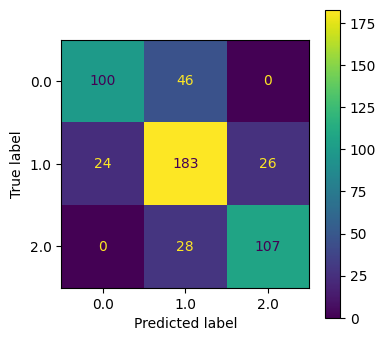

In [25]:
f1(df_predictions, "volumen_ventas")
calcular_matriz_confusion(df_predictions, "volumen_ventas")

## Conclusion

* Regresión lineal aplicando un modelo acumulativo aumenta considerablemente la puntuacion de f1 frente los algoritmos de clasificación
* Se permite establecer diferentes umbrales entre los valores consecutivos para obtener una clasifiación mejor